In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import sys

from smyleutils import averaging_utils as avg
from smyleutils import qboplot_utils as qbo
from smyleutils import colorbar_utils as cbars
from smyleutils import bootstrap_utils as boot
from smyleutils import mapplot_utils as mymaps
from smyleutils import zmplot_utils as zmplot
from smyleutils import bootstrap_utils as bootcas
from smyleutils import linfit_utils as linfit
from smyleutils import histoplot_utils as histo
import cartopy.crs as ccrs

import dask

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '30GB',
    processes = 1,
    queue = 'casper',
    local_directory='$TMPDIR',
    resource_spec='select=1:ncpus=1:mem=30GB',
    project='P04010022',
    walltime='02:00:00',
    interface='ext')

# scale up
cluster.scale(24)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [3]:
cluster

PBSCluster(d491364f, 'tcp://128.117.208.210:37673', workers=16, threads=16, memory=447.04 GiB)

In [4]:
plotpath="/glade/campaign/cgd/cas/islas/python_plots/NCAR_CW3E_SMYLE/FIGURES/"

### Read in the ERA5 QBO

In [5]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_era5_nov=xr.open_dataset(basepath+'Uzm_ERA5_day_init02.nc').Uzm
uzm_era5_nov_tr = avg.cosweightlat(uzm_era5_nov,-5,5).load()
uzm_era5_nov_tr_alllev = uzm_era5_nov_tr.sel(time=slice("1970-06-01","1971-07-31")).mean('time')
uqbo_era5 = uzm_era5_nov_tr.interp(level=50.).sel(time=slice("1970-06-01","1971-07-31")).mean('time')

uzm_era5_nov_tr_alllev = uzm_era5_nov_tr_alllev - uzm_era5_nov_tr_alllev.mean('init_year')
uqbo_era5 = uqbo_era5 - uqbo_era5.mean('init_year')
uqbo_era5_std = uqbo_era5.std('init_year')

DataArrayWeighted with weights along dimensions: lat


### Read in the JRA3Q QBO

In [6]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
uzm_jra3q_nov=xr.open_dataset(basepath+'Uzm_JRA3Q_day_init02.nc').Uzm
uzm_jra3q_nov_tr = avg.cosweightlat(uzm_jra3q_nov,-5,5).load()
uzm_jra3q_nov_tr_alllev = uzm_jra3q_nov_tr.sel(time=slice("1970-06-01","1971-07-31")).mean('time')
uzm_jra3q_nov_tr_alllev = uzm_jra3q_nov_tr_alllev.interp(pre=uzm_era5_nov_tr_alllev.level)
uqbo_jra3q = uzm_jra3q_nov_tr.interp(pre=50.).sel(time=slice("1970-06-01","1971-07-31")).mean('time')

uzm_jra3q_nov_tr_alllev = uzm_jra3q_nov_tr_alllev - uzm_jra3q_nov_tr_alllev.mean('init_year')
uqbo_jra3q = uqbo_jra3q - uqbo_jra3q.mean('init_year')
uqbo_jra3q_std = uqbo_jra3q.std('init_year')

DataArrayWeighted with weights along dimensions: lat


### Read in the model QBO

In [9]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/Uzm/"
l83_feb_uzm=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E-L83_day_init02.nc', chunks={'lat':50, 'lon':50}).Uzm.mean('M')
l32_feb_uzm=xr.open_dataset(basepath+'Uzm_BSMYLE-CW3E_day_init02.nc', chunks={'lat':50, 'lon':50}).Uzm.mean('M')

l83_anoms = l83_feb_uzm - l83_feb_uzm.mean('init_year')
l32_anoms = l32_feb_uzm - l32_feb_uzm.mean('init_year')

uzm_l83 = l83_anoms.sel(time=slice("1970-06-01","1971-07-31")).mean('time')
uzm_l32 = l32_anoms.sel(time=slice("1970-06-01","1971-07-31")).mean('time')

uzm_l83 = avg.cosweightlat(uzm_l83,-5,5)
uzm_l32 = avg.cosweightlat(uzm_l32,-5,5)

DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


### Function for calculating the vertical average from 200 to 150

In [10]:
def vertavg(dat):
    dps = [(dat.pre.isel(pre=1)-dat.pre.isel(pre=0))/2.]
    for i in np.arange(1,dat.pre.size-1,1):
        dps.append( (dat.pre.isel(pre=i+1) - dat.pre.isel(pre=i))/2. + (dat.pre.isel(pre=i) - dat.pre.isel(pre=i-1))/2.)
    dps.append( ( (dat.pre.isel(pre=dat.pre.size-1) - dat.pre.isel(pre=dat.pre.size-2))/2.) )
    dps = xr.concat(dps, dim='pre')
    dps['pre'] = dat.pre
    
    dat = dat.sel(pre=slice(200,150))
    dps = dps.sel(pre=slice(200,150))
    
    datint = ((dat*dps).sum('pre')) / dps.sum('pre')
    
    return datint

### Read in the data at 120E, 400-100 for the TEJ metric

In [11]:
basepath="/glade/campaign/cgd/cas/islas/python_savs/NCAR_CW3E_SMYLE/DATA_SORT/U_TEJ/"

In [29]:
era5 = xr.open_dataset(basepath+'U_400_100_120E_ERA5_init02.nc').ua
era5 = era5.isel(pre=slice(None,None,-1))

jra3q = xr.open_dataset(basepath+'U_400_100_120E_JRA3Q_init02.nc').ua
jra3q = jra3q.isel(pre=slice(None,None,-1))
jra3q['lat'] = era5.lat

l83 = xr.open_dataset(basepath+'U_400_100_120E_L83_init02.nc').rename({'plev':'pre'}).U
l83['pre'] = l83.pre/100.
l83['lat'] = era5.lat

l32 = xr.open_dataset(basepath+'U_400_100_120E_L32_init02.nc').rename({'plev':'pre'}).U
l32['pre'] = l32.pre/100.
l32['lat'] = era5.lat

### Get the June and July average

In [30]:
era5 = era5.sel(time=slice("1970-06-01","1970-07-31")).mean('time')
jra3q = jra3q.sel(time=slice("1970-06-01","1970-07-31")).mean('time')
l83 = l83.sel(time=slice("1970-06-01","1970-07-31")).mean('time')
l32 = l32.sel(time=slice("1970-06-01","1970-07-31")).mean('time')

### Calculate the vertical average 

In [31]:
era5 = vertavg(era5)
jra3q = vertavg(jra3q)
l83 = vertavg(l83)
l32 = vertavg(l32)

### Remove the lead dependent climatology

In [33]:
era5 = era5 - era5.mean('init_year')
jra3q = jra3q - jra3q.mean('init_year')
l83 = l83 - l83.mean('M').mean('init_year')
l32 = l32 - l32.mean('M').mean('init_year')

### Checking I can reproduce Yuan-Pu's correlation

(-30.0, 30.0)

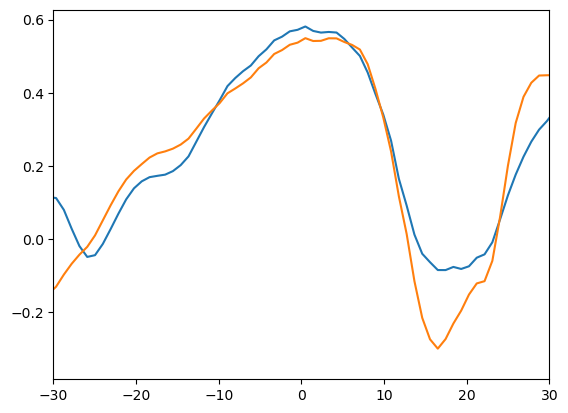

In [34]:
l83_cor = xr.corr(l83.mean('M'), era5, dim='init_year')
l32_cor = xr.corr(l32.mean('M'), era5, dim='init_year')

plt.plot(l32_cor.lat, l32_cor)
plt.plot(l83_cor.lat, l83_cor)
plt.xlim(-30,30)

### Generate bootstrap samples for single member sampling uncertainty

In [ ]:
boot_l83 = [] ; boot_l32 = []
for iyear in np.arange(0,era5.init_year.size,1):
    bootdat_l83 = boot.bootgen(l83.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l83.append(bootdat_l83)
    bootdat_l32 = boot.bootgen(l32.isel(init_year=iyear), nsamples=1, seed=iyear).isel(isample=0)
    boot_l32.append(bootdat_l32)
 
boot_l83 = xr.concat(boot_l83, dim=era5.init_year)
boot_l32 = xr.concat(boot_l32, dim=era5.init_year)

### Westerly and easterly QBO composites

In [42]:
west_uzm_era5 = uzm_era5_nov_tr_alllev.isel(init_year = uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_uzm_era5 = uzm_era5_nov_tr_alllev.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_uzm_jra3q = uzm_jra3q_nov_tr_alllev.isel(init_year = uqbo_jra3q.values > 0.5*uqbo_jra3q_std.values)
east_uzm_jra3q = uzm_jra3q_nov_tr_alllev.isel(init_year = uqbo_jra3q.values < -0.5*uqbo_jra3q_std.values)

west_uzm_l83 = uzm_l83.isel(init_year = uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_uzm_l83 = uzm_l83.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_uzm_l32 = uzm_l32.isel(init_year = uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_uzm_l32 = uzm_l32.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_era5 = era5.isel(init_year = uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_era5 = era5.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_jra3q = jra3q.isel(init_year = uqbo_jra3q.values > 0.5*uqbo_jra3q_std.values)
east_jra3q = jra3q.isel(init_year = uqbo_jra3q.values < -0.5*uqbo_jra3q_std.values)


west_boot_l83 = boot_l83.isel(init_year= uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_boot_l83 = boot_l83.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_boot_l32 = boot_l32.isel(init_year= uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_boot_l32 = boot_l32.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_l83 = l83.isel(init_year = uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_l83 = l83.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_l32 = l32.isel(init_year = uqbo_era5.values > 0.5*uqbo_era5_std.values)
east_l32 = l32.isel(init_year = uqbo_era5.values < -0.5*uqbo_era5_std.values)

west_era5_m = west_era5.mean('init_year')
east_era5_m = east_era5.mean('init_year')

west_jra3q_m = west_jra3q.mean('init_year')
east_jra3q_m = east_jra3q.mean('init_year')


west_boot_l83_m = west_boot_l83.mean('init_year')
east_boot_l83_m = east_boot_l83.mean('init_year')

west_boot_l32_m = west_boot_l32.mean('init_year')
east_boot_l32_m = east_boot_l32.mean('init_year')

west_l83_m = west_l83.mean('init_year')
east_l83_m = east_l83.mean('init_year')

west_l32_m = west_l32.mean('init_year')
east_l32_m = east_l32.mean('init_year')

west_era5_10s10n = avg.cosweightlat(west_era5_m,-10,10)
east_era5_10s10n = avg.cosweightlat(east_era5_m,-10,10)

west_jra3q_10s10n = avg.cosweightlat(west_jra3q_m,-10,10)
east_jra3q_10s10n = avg.cosweightlat(east_jra3q_m,-10,10)

west_l83_10s10n = avg.cosweightlat(west_boot_l83_m,-10,10)
east_l83_10s10n = avg.cosweightlat(east_boot_l83_m,-10,10)

west_l32_10s10n = avg.cosweightlat(west_boot_l32_m,-10,10)
east_l32_10s10n = avg.cosweightlat(east_boot_l32_m,-10,10)

west_l83_em_10s10n = avg.cosweightlat(west_l83_m, -10, 10)
east_l83_em_10s10n = avg.cosweightlat(east_l83_m, -10, 10)

west_l32_em_10s10n = avg.cosweightlat(west_l32_m, -10, 10)
east_l32_em_10s10n = avg.cosweightlat(east_l32_m, -10, 10)



DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat
DataArrayWeighted with weights along dimensions: lat


In [44]:
dif_qbo_era5 = west_uzm_era5.mean('init_year') - east_uzm_era5.mean('init_year')
dif_qbo_jra3q = west_uzm_jra3q.mean('init_year') - east_uzm_jra3q.mean('init_year')
dif_qbo_l83 = west_uzm_l83.mean('init_year') - east_uzm_l83.mean('init_year')
dif_qbo_l83 = dif_qbo_l83.interp(ilev=dif_qbo_era5.level)
dif_qbo_l32 = west_uzm_l32.mean('init_year') - east_uzm_l32.mean('init_year')
dif_qbo_l32 = dif_qbo_l32.interp(ilev=dif_qbo_era5.level)

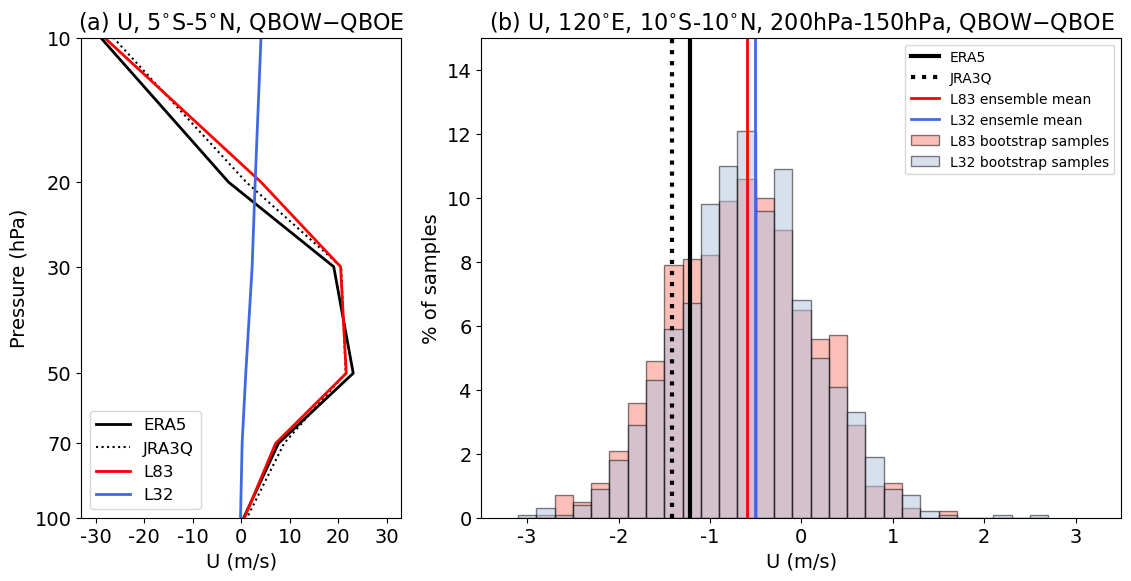

In [47]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_axes([0.05,0.7,0.2,0.3])

ax.plot(dif_qbo_era5, -np.log10(dif_qbo_era5.level), color='black', linewidth=2, label='ERA5')
ax.plot(dif_qbo_jra3q, - np.log10(dif_qbo_jra3q.pre), color='black', linestyle='dotted', label='JRA3Q')
ax.plot(dif_qbo_l83, -np.log10(dif_qbo_l83.ilev), color='red', linewidth=2, label='L83')
ax.plot(dif_qbo_l32, -np.log10(dif_qbo_l32.ilev), color='royalblue', linewidth=2, label='L32')
ax.set_ylim(-np.log10(100), -np.log10(10))
ax.set_xlim(-33,33)
ax.set_xticks([-30,-20,-10,0,10,20,30])
ax.set_xticklabels(['-30','-20','-10','0','10','20','30'], fontsize=14)
ax.set_xlabel('U (m/s)', fontsize=14)
ax.set_ylabel('Pressure (hPa)', fontsize=14)
ax.set_title('(a) U, 5$^{\circ}$S-5$^{\circ}$N, QBOW$-$QBOE', fontsize=16)
#ax.set_ylim(-np.log10(1000),-np.log10(100))
ax.set_yticks([-np.log10(100),-np.log10(70), -np.log10(50),-np.log10(30),-np.log10(20),-np.log10(10)])
ax.set_yticklabels(['100','70','50','30','20','10'], fontsize=14)
ax.legend(loc='lower left', fontsize=12)

difboot_l83 = west_l83_10s10n - east_l83_10s10n
difboot_l32 = west_l32_10s10n - east_l32_10s10n
difera5 = west_era5_10s10n - east_era5_10s10n
difjra3q = west_jra3q_10s10n - east_jra3q_10s10n

dif_l83 = west_l83_em_10s10n.mean('M') - east_l83_em_10s10n.mean('M')
dif_l32 = west_l32_em_10s10n.mean('M') - east_l32_em_10s10n.mean('M')

ax = histo.plothisto(fig, difboot_l83, np.arange(-3,3,0.2),0.3,0.7,0.7,1,percent=True, label='L83 bootstrap samples', color='salmon', alpha=0.5)
ax.set_ylim(0,15)
ax.set_yticks([0,2,4,6,8,10,12,14])
ax.set_yticklabels(['0','2','4','6','8','10','12','14'], fontsize=14)
ax.set_ylabel('% of samples', fontsize=14)
ax.set_xlim(-3.5,3.5)
ax.set_xticks([-3,-2,-1,0,1,2,3])
ax.set_xticklabels(['-3','-2','-1','0','1','2','3'], fontsize=14)
ax.set_xlabel('U (m/s)', fontsize=14)
ax.set_title('(b) U, 120$^{\circ}$E, 10$^{\circ}$S-10$^{\circ}$N, 200hPa-150hPa, QBOW$-$QBOE', fontsize=16)
ax = histo.oplothisto(ax, difboot_l32, np.arange(-3,3,0.2),percent=True, label='L32 bootstrap samples', color='lightsteelblue', alpha=0.5)


ax.plot([difera5, difera5],[0,25], color='black', linewidth=3, label='ERA5')
ax.plot([difjra3q, difjra3q],[0,25], color='black', linewidth=3, linestyle='dotted', label='JRA3Q')
ax.plot([dif_l83, dif_l83],[0,25], color='red', linewidth=2, label='L83 ensemble mean')
ax.plot([dif_l32,dif_l32], [0,25], color='royalblue', linewidth=2, label='L32 ensemle mean')

ax.legend(loc='upper right')

fig.savefig(plotpath+'fig16.png', bbox_inches='tight', facecolor='white')

